Loading Data

In [3]:
import warnings
import pandas as pd
import os
import time

def safe_load_signal(file_path, retries=3, delay=0.5):
    """Attempts to load a signal file safely with retries and delays."""
    for attempt in range(retries):
        try:
            with warnings.catch_warnings():
                warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)
                df = pd.read_csv(file_path, delim_whitespace=True, skiprows=2, encoding='ISO-8859-1', header=None)
            df.columns = ['Time (ms)', 'Voltage (uV)']
            df = df.apply(pd.to_numeric, errors='coerce').dropna()
            return df["Voltage (uV)"].to_numpy()
        except Exception as e:
            print(f"[{file_path}] Attempt {attempt + 1} failed: {e}")
            time.sleep(delay)
    print(f"[{file_path}] Failed to load after {retries} attempts.")
    return None

from tqdm import tqdm

def load_signals_from_folder_with_progress(folder_path, log_file="load_log.txt"):
    signals = {}
    failed_files = []

    with open(log_file, "w") as log:
        for file in tqdm(os.listdir(folder_path), desc=f"Loading {folder_path}"):
            if file.endswith(".txt"):
                file_path = os.path.join(folder_path, file)
                signal = safe_load_signal(file_path)
                if signal is not None:
                    signals[file] = signal
                    log.write(f"SUCCESS: {file_path}\n")
                else:
                    failed_files.append(file)
                    log.write(f"FAILED: {file_path}\n")

    if failed_files:
        print(f"\n⚠️ Failed to load {len(failed_files)} files. See '{log_file}' for details.")
    else:
        print("\n✅ All files loaded successfully.")

    return signals


estrogen_signals = load_signals_from_folder_with_progress("Estrogen", log_file="estrogen_load_log.txt")
control_signals = load_signals_from_folder_with_progress("Control", log_file="control_load_log.txt")



Loading Estrogen: 100%|█████████████████████████| 33/33 [05:04<00:00,  9.23s/it]



✅ All files loaded successfully.


Loading Control: 100%|██████████████████████████| 33/33 [05:57<00:00, 10.84s/it]


✅ All files loaded successfully.


Global Variables

In [159]:
#Global Contstants
SPIKE_THRESHOLD = -30  # in microvolts
REFRACTORY_MS = 1             # ms

BURST_START_SPIKES = 4        # ≥ 4 spikes
BURST_START_WINDOW_MS = 50    # initial burst window in ms
BURST_CONTINUE_GAP_MS = 25    # burst continues unless gap ≥ 25 ms


Signal Validation

In [160]:
import numpy as np
import matplotlib.pyplot as plt

def plot_full_signal(sample_name, group_dict, fs=50000):
    signal = group_dict[sample_name]
    time_ms = np.arange(len(signal)) / fs * 1000

    if group_dict is control_signals:
        color = 'red'
    else:
        color = 'blue'


    plt.figure(figsize=(16, 5))
    plt.plot(time_ms, signal, color=color, linewidth=0.3)
    plt.title(f"Full Signal – Sample {sample_name}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (µV)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



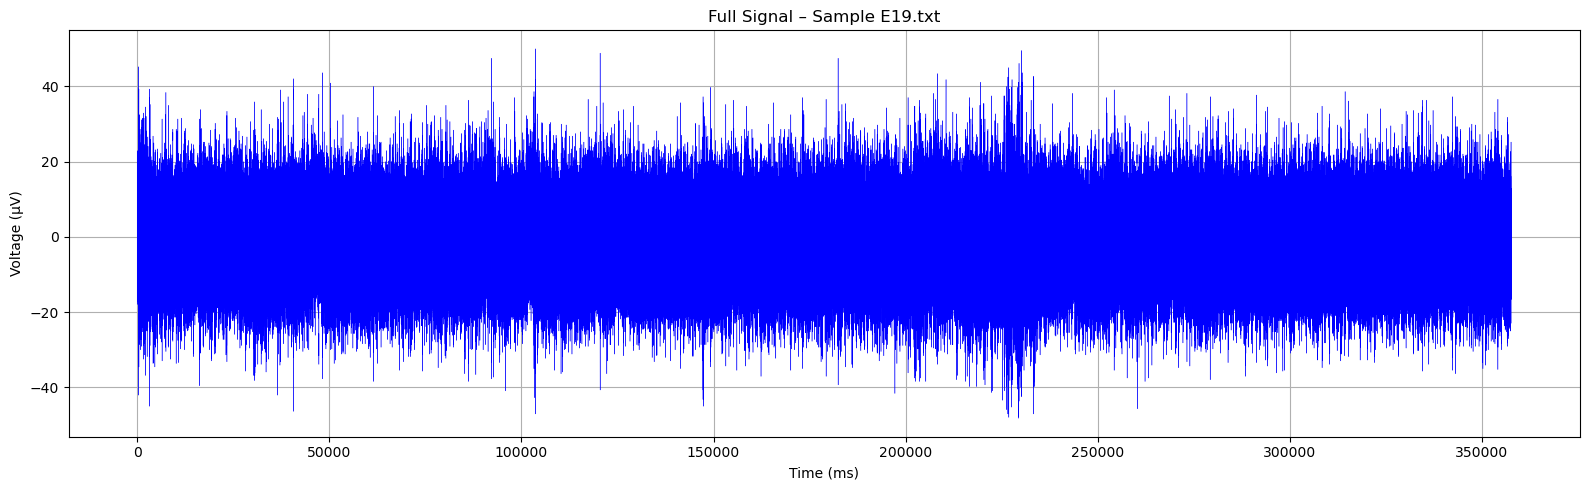

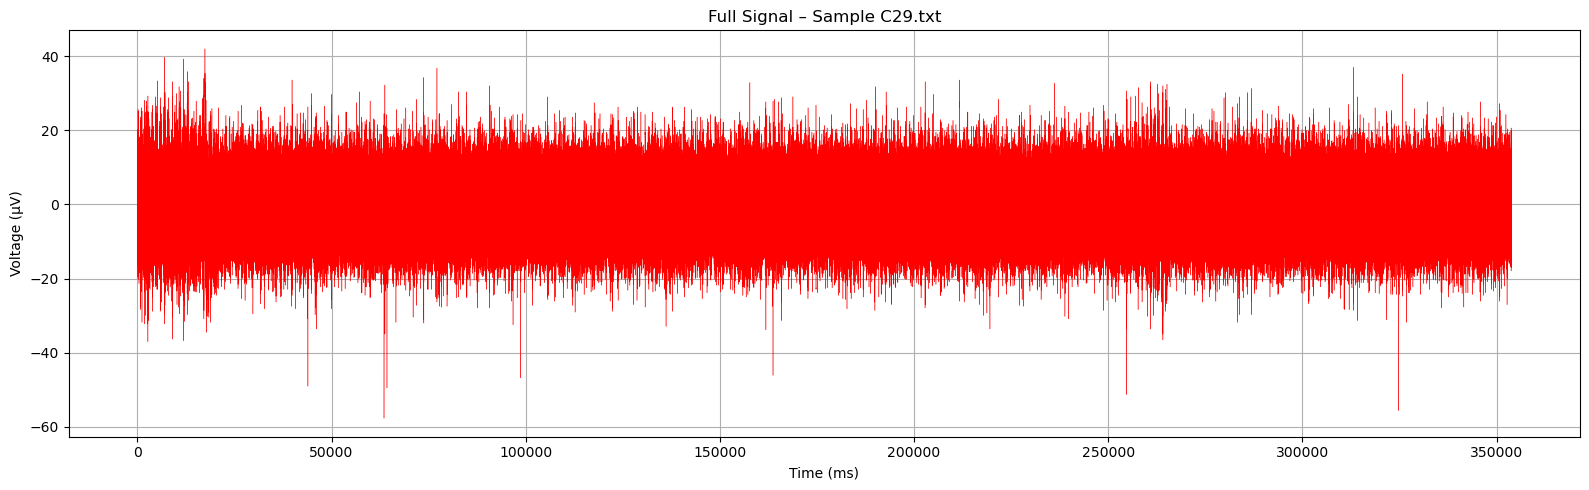

In [161]:
plot_full_signal("E19.txt", group_dict=estrogen_signals)
plot_full_signal("C29.txt", group_dict=control_signals)


In [ ]:
Spike Detection Algorithm

In [162]:
def detect_spikes(signal, fs=50000):
    refractory_samples = int(0.001 * fs)
    spike_indices = []
    last_spike = -refractory_samples

    for i in range(len(signal)):
        if signal[i] < SPIKE_THRESHOLD and (i - last_spike) >= refractory_samples:
            spike_indices.append(i)
            last_spike = i

    return np.array(spike_indices)



Signal Verification using second-long plots and ISIs

In [163]:
def verify_sample(sample_name, group_dict, fs=50000, second=354):
    signal = group_dict[sample_name]
    start = second * fs
    end = (second + 1) * fs
    segment = signal[start:end]
    time_ms = np.arange(start, end) / fs * 1000

    spikes = detect_spikes(segment, fs)
    spike_times = spikes / fs
    isi = np.diff(spike_times)

    print(f"\n🧪 Sample: {sample_name} – {second}th Second")
    print(f"Spikes detected: {len(spikes)}")
    print("First 5 ISIs (s):", isi[:5] if len(isi) > 0 else "None")

    if group_dict is control_signals:
        color = 'red'
    else:
        color = 'blue'

    plt.figure(figsize=(12, 4))
    plt.plot(time_ms, segment, color = color)
    plt.title(f"{sample_name} – {second}th Second")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (µV)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




🧪 Sample: E9.txt – 354th Second
Spikes detected: 76
First 5 ISIs (s): [0.00136 0.0014  0.11624 0.00118 0.00124]


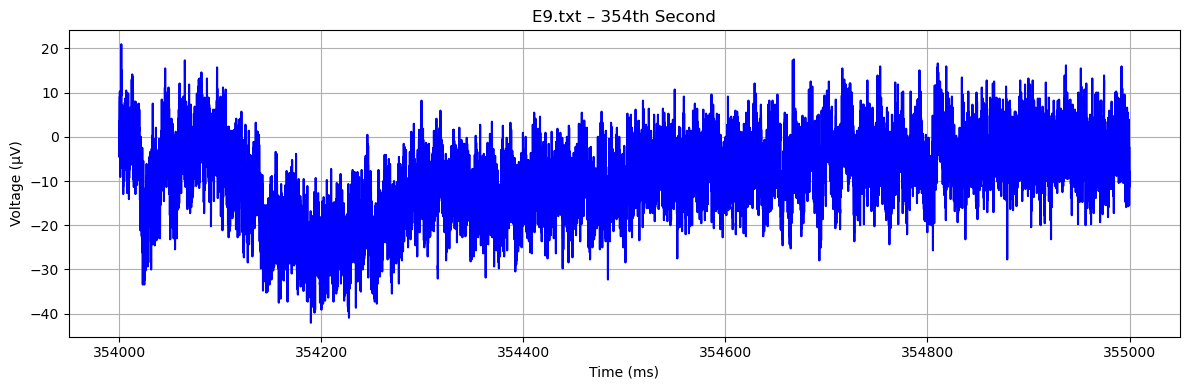


🧪 Sample: C5.txt – 354th Second
Spikes detected: 0
First 5 ISIs (s): None


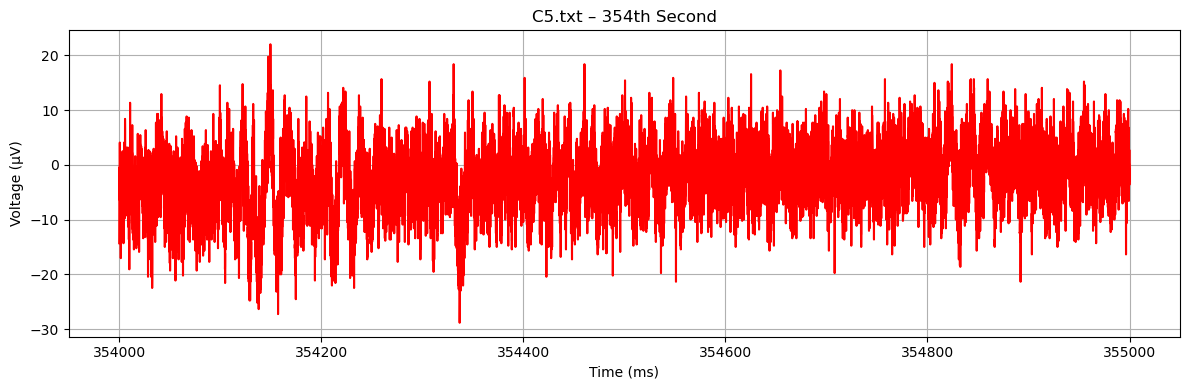

In [164]:
verify_sample("E9.txt", group_dict=estrogen_signals)
verify_sample("C5.txt", group_dict=control_signals)

Burst Detection Algorithm

In [165]:
def plot_one_second_with_bursts(signal, start_sec=3, fs=50000, title="Sample"):
    import matplotlib.pyplot as plt

    # Parameters
    start_idx = int(start_sec * fs)
    end_idx = start_idx + fs
    segment = signal[start_idx:end_idx]
    time_ms = np.arange(len(segment)) / fs * 1000

    # Detect spikes
    refractory_samples = int(REFRACTORY_MS * fs / 1000)
    spike_indices = []
    last_spike = -refractory_samples

    for i in range(len(segment)):
        if segment[i] < SPIKE_THRESHOLD and (i - last_spike) >= refractory_samples:
            spike_indices.append(i)
            last_spike = i

    spike_times_sec = np.array(spike_indices) / fs

    # Detect bursts
    bursts = []
    i = 0
    while i <= len(spike_times_sec) - BURST_START_SPIKES:
        window = spike_times_sec[i + BURST_START_SPIKES - 1] - spike_times_sec[i]
        if window <= BURST_START_WINDOW_MS / 1000:
            burst = [spike_times_sec[i]]
            j = i + 1
            while j < len(spike_times_sec) and (spike_times_sec[j] - burst[-1]) < (BURST_CONTINUE_GAP_MS / 1000):
                burst.append(spike_times_sec[j])
                j += 1
            if len(burst) >= BURST_START_SPIKES:
                bursts.append(burst)
            i = j
        else:
            i += 1

    # Intra-burst ISIs
    intra_isis = []
    for b in bursts:
        if len(b) > 1:
            intra_isis.extend(np.diff(b))
    
    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(time_ms, segment, label="Signal", alpha=0.7)

    spike_plot_times = np.array(spike_indices) / fs * 1000
    spike_plot_amps = segment[spike_indices]
    plt.scatter(spike_plot_times, spike_plot_amps, color='red', label="Spikes")

    for b in bursts:
        burst_start = b[0] * 1000
        burst_end = b[-1] * 1000
        plt.axvspan(burst_start, burst_end, color='orange', alpha=0.3)

    plt.title(f"{title} - 1-Second Segment (Start @ {start_sec}s)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (µV)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Summary
    print(f"🔹 Number of bursts: {len(bursts)}")
    print(f"🔹 Mean intra-burst ISI: {np.mean(intra_isis) * 1000:.2f} ms" if intra_isis else "No bursts with ISIs")


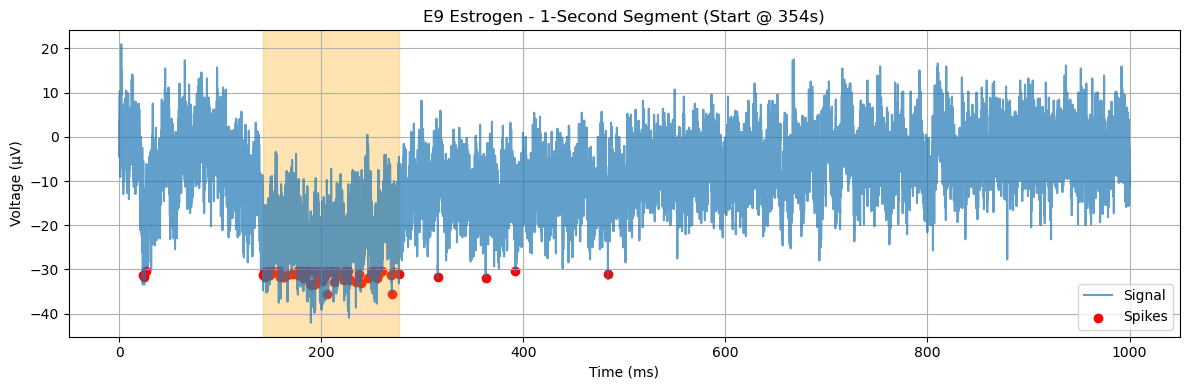

🔹 Number of bursts: 1
🔹 Mean intra-burst ISI: 1.98 ms


In [166]:
plot_one_second_with_bursts(estrogen_signals["E9.txt"], start_sec=354, title="E9 Estrogen")


Feature Extraction

In [167]:
def extract_spike_features(data, fs=50000):
    window_size = fs  # 1 second per window
    num_windows = len(data) // window_size
    feature_list = []

    refractory_samples = int(REFRACTORY_MS * fs / 1000)
    burst_start_window_s = BURST_START_WINDOW_MS / 1000
    burst_continue_gap_s = BURST_CONTINUE_GAP_MS / 1000

    for i in range(num_windows):
        segment = data[i * window_size : (i + 1) * window_size]

        # Spike detection
        spike_indices = []
        last_spike = -refractory_samples
        for idx in range(len(segment)):
            if segment[idx] < SPIKE_THRESHOLD and (idx - last_spike) >= refractory_samples:
                spike_indices.append(idx)
                last_spike = idx

        spike_indices = np.array(spike_indices)
        spike_times_sec = spike_indices / fs
        isi_sec = np.diff(spike_times_sec)

        # Spike amplitude features
        spike_amplitudes = segment[spike_indices] if len(spike_indices) > 0 else np.array([np.nan])
        amplitude_min = np.min(spike_amplitudes) if len(spike_amplitudes) > 0 else np.nan
        amplitude_mean = np.mean(spike_amplitudes) if len(spike_amplitudes) > 0 else np.nan
        amplitude_std = np.std(spike_amplitudes) if len(spike_amplitudes) > 0 else np.nan

        # Burst detection
        bursts = []
        i_spike = 0
        while i_spike <= len(spike_times_sec) - BURST_START_SPIKES:
            window = spike_times_sec[i_spike + BURST_START_SPIKES - 1] - spike_times_sec[i_spike]
            if window <= burst_start_window_s:
                burst = [spike_times_sec[i_spike]]
                j = i_spike + 1
                while j < len(spike_times_sec) and (spike_times_sec[j] - burst[-1]) < burst_continue_gap_s:
                    burst.append(spike_times_sec[j])
                    j += 1
                if len(burst) >= BURST_START_SPIKES:
                    bursts.append(burst)
                i_spike = j
            else:
                i_spike += 1

        # Burst features
        burst_durations = []
        intra_rates = []
        intra_isis = []
        spikes_in_bursts = 0

        for b in bursts:
            dur_sec = b[-1] - b[0]
            dur_ms = dur_sec * 1000
            if dur_ms > 0 and len(b) > 1:
                burst_durations.append(dur_sec)
                rate_hz = ((len(b) - 1) / dur_ms) * 1000
                intra_rates.append(rate_hz)
                intra_isis.extend(np.diff(b))
                spikes_in_bursts += len(b)

        firing_rate = len(spike_times_sec)
        isi_mean = np.mean(isi_sec) if len(isi_sec) > 0 else 0
        burstiness = spikes_in_bursts / firing_rate if firing_rate > 0 else 0

        feature_list.append({
            "Window": i + 1,
            "Firing Rate (Hz)": firing_rate,
            "Mean ISI (s)": isi_mean,
            "Spike Amplitude Min (µV)": amplitude_min,
            "Spike Amplitude Mean (µV)": amplitude_mean,
            "Spike Amplitude Std (µV)": amplitude_std,
            "Avg Burst Duration (s)": np.mean(burst_durations) if burst_durations else 0,
            "Avg Intra-Burst Rate (Hz)": np.mean(intra_rates) if intra_rates else 0,
            "Avg Intra-Burst ISI (s)": np.mean(intra_isis) if intra_isis else 0,
            "Burst Count": len(bursts),
            "Burstiness Ratio": burstiness
        })

    return pd.DataFrame(feature_list)


        

        



In [168]:
def extract_features_for_group(signal_dict, group_label, fs=50000):
    all_features = []

    for sample_name, signal in signal_dict.items():
        df = extract_spike_features(signal, fs=fs)
        df["Sample"] = sample_name
        df["Group"] = group_label
        all_features.append(df)

    return pd.concat(all_features, ignore_index=True)


In [169]:
# Run extraction
estrogen_features = extract_features_for_group(estrogen_signals, group_label="Estrogen")
control_features = extract_features_for_group(control_signals, group_label="Control")

# Combine into one dataset
all_features_df = pd.concat([estrogen_features, control_features], ignore_index=True)

# Preview
print(all_features_df.head())


   Window  Firing Rate (Hz)  Mean ISI (s)  Spike Amplitude Min (µV)  \
0       1                 0           0.0                       NaN   
1       2                 0           0.0                       NaN   
2       3                 0           0.0                       NaN   
3       4                 0           0.0                       NaN   
4       5                 0           0.0                       NaN   

   Spike Amplitude Mean (µV)  Spike Amplitude Std (µV)  \
0                        NaN                       NaN   
1                        NaN                       NaN   
2                        NaN                       NaN   
3                        NaN                       NaN   
4                        NaN                       NaN   

   Avg Burst Duration (s)  Avg Intra-Burst Rate (Hz)  Avg Intra-Burst ISI (s)  \
0                     0.0                        0.0                      0.0   
1                     0.0                        0.0          

In [ ]:
# Calculate the mean of each feature per sample
sample_summary_df = all_features_df.groupby(["Sample", "Group"]).mean(numeric_only=True).reset_index()

# Show the summary
print(sample_summary_df.head())


In [153]:
# Display extracted features for each sample separately
for sample_name in all_features_df["Sample"].unique():
    sample_df = all_features_df[all_features_df["Sample"] == sample_name]

    print(f"\n🔎 Features for Sample: {sample_name} (Group: {sample_df['Group'].iloc[0]})")
    display(sample_df.drop(columns=["Group", "Sample"]))  # cleaner output



🔎 Features for Sample: E9.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
0,1,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
1,2,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
2,3,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
3,4,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
4,5,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
352,353,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
353,354,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
354,355,76,0.006139,-35.45,-31.336184,1.070919,0.13448,505.651398,0.001978,1,0.907895
355,356,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E8.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
357,1,26,0.028576,-36.82,-31.555000,1.733525,0.03953,173.282941,0.005647,2,0.615385
358,2,4,0.239080,-31.59,-31.080000,0.336378,0.00000,0.000000,0.000000,0,0.000000
359,3,2,0.001520,-30.68,-30.565000,0.115000,0.00000,0.000000,0.000000,0,0.000000
360,4,7,0.005517,-31.36,-30.582857,0.380403,0.03310,181.268882,0.005517,1,1.000000
361,5,5,0.118735,-32.05,-31.092000,0.649874,0.00000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
709,353,1,0.000000,-30.23,-30.230000,0.000000,0.00000,0.000000,0.000000,0,0.000000
710,354,1,0.000000,-30.91,-30.910000,0.000000,0.00000,0.000000,0.000000,0,0.000000
711,355,3,0.275390,-31.14,-30.910000,0.187794,0.00000,0.000000,0.000000,0,0.000000
712,356,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E20.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
714,1,2,0.12652,-32.05,-31.935,0.115,0.0,0.0,0.0,0,0.0
715,2,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
716,3,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
717,4,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
718,5,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1066,353,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1067,354,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1068,355,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1069,356,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: E21.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
1071,1,4,0.006707,-34.09,-31.3075,1.616947,0.02012,149.105368,0.006707,1,1.0
1072,2,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
1073,3,1,0.000000,-30.45,-30.4500,0.000000,0.00000,0.000000,0.000000,0,0.0
1074,4,2,0.017200,-32.50,-31.4750,1.025000,0.00000,0.000000,0.000000,0,0.0
1075,5,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1423,353,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
1424,354,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
1425,355,1,0.000000,-30.91,-30.9100,0.000000,0.00000,0.000000,0.000000,0,0.0
1426,356,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0



🔎 Features for Sample: E23.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
1428,1,4,0.027713,-32.05,-31.252500,0.497261,0.0,0.0,0.0,0,0.0
1429,2,0,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1430,3,3,0.243470,-32.27,-31.436667,0.750881,0.0,0.0,0.0,0,0.0
1431,4,2,0.017300,-32.05,-31.250000,0.800000,0.0,0.0,0.0,0,0.0
1432,5,1,0.000000,-31.59,-31.590000,0.000000,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1780,353,0,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1781,354,0,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
1782,355,1,0.000000,-30.23,-30.230000,0.000000,0.0,0.0,0.0,0,0.0
1783,356,0,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: E22.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
1785,1,4,0.006227,-30.91,-30.455,0.277624,0.01868,160.599572,0.006227,1,1.0
1786,2,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
1787,3,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
1788,4,2,0.017420,-30.91,-30.680,0.230000,0.00000,0.000000,0.000000,0,0.0
1789,5,1,0.000000,-30.68,-30.680,0.000000,0.00000,0.000000,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2137,353,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
2138,354,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
2139,355,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
2140,356,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0



🔎 Features for Sample: E32.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
2142,1,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
2143,2,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
2144,3,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
2145,4,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
2146,5,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2494,353,1,0.000000,-30.23,-30.230000,0.000000,0.00000,0.000000,0.000000,0,0.000000
2495,354,2,0.004820,-31.36,-30.795000,0.565000,0.00000,0.000000,0.000000,0,0.000000
2496,355,108,0.004081,-39.32,-31.689537,1.596878,0.27672,372.217404,0.002687,1,0.962963
2497,356,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E26.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
2499,1,0,0.000000,NaN,NaN,NaN,0.00000,0.00000,0.000000,0,0.000000
2500,2,0,0.000000,NaN,NaN,NaN,0.00000,0.00000,0.000000,0,0.000000
2501,3,0,0.000000,NaN,NaN,NaN,0.00000,0.00000,0.000000,0,0.000000
2502,4,0,0.000000,NaN,NaN,NaN,0.00000,0.00000,0.000000,0,0.000000
2503,5,0,0.000000,NaN,NaN,NaN,0.00000,0.00000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2851,353,0,0.000000,NaN,NaN,NaN,0.00000,0.00000,0.000000,0,0.000000
2852,354,2,0.573860,-31.59,-31.135000,0.455000,0.00000,0.00000,0.000000,0,0.000000
2853,355,66,0.003654,-32.95,-31.029091,0.681784,0.14644,437.03906,0.002288,1,0.984848
2854,356,0,0.000000,NaN,NaN,NaN,0.00000,0.00000,0.000000,0,0.000000



🔎 Features for Sample: E27.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
2856,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
2857,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
2858,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
2859,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
2860,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3208,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3209,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3210,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3211,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: E25.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
3213,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3214,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3215,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3216,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3217,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3565,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3566,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3567,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3568,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: E31.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
3570,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3571,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3572,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3573,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3574,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3922,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3923,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3924,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
3925,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: E19.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
3927,1,12,0.016964,-38.64,-32.764167,2.884942,0.02022,346.191889,0.002889,1,0.666667
3928,2,3,0.168750,-32.50,-31.363333,0.926727,0.00000,0.000000,0.000000,0,0.000000
3929,3,2,0.372040,-32.95,-32.155000,0.795000,0.00000,0.000000,0.000000,0,0.000000
3930,4,8,0.004826,-38.41,-32.556250,2.622189,0.03378,207.223209,0.004826,1,1.000000
3931,5,6,0.094880,-31.59,-30.870000,0.479965,0.00000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
4279,353,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
4280,354,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
4281,355,3,0.001080,-31.14,-30.833333,0.286860,0.00000,0.000000,0.000000,0,0.000000
4282,356,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E18.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
4284,1,3,0.10326,-30.91,-30.456667,0.320555,0.0,0.0,0.0,0,0.0
4285,2,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
4286,3,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
4287,4,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
4288,5,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4636,353,2,0.01164,-30.91,-30.910000,0.000000,0.0,0.0,0.0,0,0.0
4637,354,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
4638,355,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
4639,356,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: E30.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
4641,1,0,0.00000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.00000
4642,2,0,0.00000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.00000
4643,3,0,0.00000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.00000
4644,4,1,0.00000,-30.68,-30.680000,0.000000,0.00000,0.000000,0.000000,0,0.00000
4645,5,0,0.00000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...
4993,353,0,0.00000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.00000
4994,354,0,0.00000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.00000
4995,355,86,0.00525,-35.23,-31.387558,1.123106,0.09068,302.382924,0.002296,2,0.94186
4996,356,1,0.00000,-33.64,-33.640000,0.000000,0.00000,0.000000,0.000000,0,0.00000



🔎 Features for Sample: E24.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
4998,1,6,0.082128,-31.59,-30.831667,0.409773,0.0193,207.253886,0.004825,1,0.833333
4999,2,0,0.000000,NaN,NaN,NaN,0.0000,0.000000,0.000000,0,0.000000
5000,3,1,0.000000,-30.45,-30.450000,0.000000,0.0000,0.000000,0.000000,0,0.000000
5001,4,1,0.000000,-31.14,-31.140000,0.000000,0.0000,0.000000,0.000000,0,0.000000
5002,5,1,0.000000,-32.05,-32.050000,0.000000,0.0000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
5350,353,0,0.000000,NaN,NaN,NaN,0.0000,0.000000,0.000000,0,0.000000
5351,354,0,0.000000,NaN,NaN,NaN,0.0000,0.000000,0.000000,0,0.000000
5352,355,1,0.000000,-32.05,-32.050000,0.000000,0.0000,0.000000,0.000000,0,0.000000
5353,356,0,0.000000,NaN,NaN,NaN,0.0000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E29.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
5355,1,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
5356,2,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
5357,3,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
5358,4,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
5359,5,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
5707,353,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
5708,354,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
5709,355,54,0.008323,-33.64,-31.253889,0.844513,0.11968,426.136364,0.002347,1,0.962963
5710,356,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E15.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
5712,1,2,0.756000,-31.14,-30.685000,0.455000,0.000000,0.000000,0.000000,0,0.000000
5713,2,3,0.438030,-32.27,-31.666667,0.565705,0.000000,0.000000,0.000000,0,0.000000
5714,3,3,0.002020,-31.59,-31.060000,0.468828,0.000000,0.000000,0.000000,0,0.000000
5715,4,3,0.001290,-32.73,-31.816667,0.984457,0.000000,0.000000,0.000000,0,0.000000
5716,5,2,0.614360,-31.36,-31.135000,0.225000,0.000000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
6064,353,5,0.032155,-33.64,-31.866000,1.476775,0.000000,0.000000,0.000000,0,0.000000
6065,354,3,0.189540,-32.50,-31.363333,0.851678,0.000000,0.000000,0.000000,0,0.000000
6066,355,146,0.005367,-45.00,-32.094863,2.288487,0.115487,368.879749,0.002493,3,0.972603
6067,356,6,0.042396,-31.59,-30.606667,0.501520,0.000000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E14.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
6069,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
6070,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
6071,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
6072,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
6073,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6421,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
6422,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
6423,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
6424,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: E28.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
6426,1,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
6427,2,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
6428,3,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
6429,4,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
6430,5,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
6778,353,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
6779,354,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
6780,355,82,0.005877,-39.09,-31.371341,1.344839,0.13940,523.672884,0.001910,1,0.902439
6781,356,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E16.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
6783,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
6784,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
6785,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
6786,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
6787,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7135,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
7136,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
7137,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
7138,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: E17.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
7140,1,9,0.084110,-31.36,-30.705556,0.363321,0.02068,241.779497,0.004136,1,0.666667
7141,2,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
7142,3,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
7143,4,5,0.004205,-30.91,-30.544000,0.231828,0.01682,237.812128,0.004205,1,1.000000
7144,5,1,0.000000,-30.91,-30.910000,0.000000,0.00000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
7492,353,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
7493,354,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
7494,355,1,0.000000,-30.45,-30.450000,0.000000,0.00000,0.000000,0.000000,0,0.000000
7495,356,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E13.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
7497,1,4,0.00698,-31.59,-31.0225,0.377649,0.02094,143.266476,0.00698,1,1.0
7498,2,1,0.00000,-30.23,-30.2300,0.000000,0.00000,0.000000,0.00000,0,0.0
7499,3,2,0.00152,-31.14,-30.9100,0.230000,0.00000,0.000000,0.00000,0,0.0
7500,4,1,0.00000,-30.68,-30.6800,0.000000,0.00000,0.000000,0.00000,0,0.0
7501,5,0,0.00000,NaN,NaN,NaN,0.00000,0.000000,0.00000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7849,353,0,0.00000,NaN,NaN,NaN,0.00000,0.000000,0.00000,0,0.0
7850,354,1,0.00000,-34.09,-34.0900,0.000000,0.00000,0.000000,0.00000,0,0.0
7851,355,2,0.76384,-37.50,-34.2050,3.295000,0.00000,0.000000,0.00000,0,0.0
7852,356,0,0.00000,NaN,NaN,NaN,0.00000,0.000000,0.00000,0,0.0



🔎 Features for Sample: E12.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
7854,1,3,0.1162,-31.14,-30.68,0.325269,0.0,0.0,0.0,0,0.0
7855,2,0,0.0000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
7856,3,0,0.0000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
7857,4,1,0.0000,-30.23,-30.23,0.000000,0.0,0.0,0.0,0,0.0
7858,5,0,0.0000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8206,353,0,0.0000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
8207,354,0,0.0000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
8208,355,0,0.0000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
8209,356,0,0.0000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: E10.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
8211,1,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000
8212,2,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000
8213,3,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000
8214,4,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000
8215,5,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
8563,353,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000
8564,354,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000
8565,355,87,0.005821,-38.64,-31.451724,1.360663,0.071767,228.703270,0.002691,3,0.954023
8566,356,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E11.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
8568,1,2,0.14996,-31.82,-31.705,0.115,0.0,0.0,0.0,0,0.0
8569,2,1,0.00000,-30.91,-30.910,0.000,0.0,0.0,0.0,0,0.0
8570,3,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
8571,4,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
8572,5,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8920,353,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
8921,354,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
8922,355,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
8923,356,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: E3.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
8925,1,39,0.019684,-48.18,-32.051026,3.018215,0.032705,146.028411,0.006230,4,0.641026
8926,2,16,0.047873,-32.73,-30.838125,0.752738,0.000000,0.000000,0.000000,0,0.000000
8927,3,2,0.370660,-32.27,-31.360000,0.910000,0.000000,0.000000,0.000000,0,0.000000
8928,4,12,0.021242,-42.50,-32.539167,3.162450,0.034380,261.780105,0.003820,1,0.833333
8929,5,13,0.046770,-31.82,-30.996154,0.508127,0.017160,233.100233,0.004290,1,0.384615
...,...,...,...,...,...,...,...,...,...,...,...
9277,353,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000
9278,354,6,0.055876,-31.36,-30.606667,0.426328,0.000000,0.000000,0.000000,0,0.000000
9279,355,6,0.007864,-32.50,-31.551667,0.940911,0.003460,867.052023,0.001153,1,0.666667
9280,356,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E2.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
9282,1,44,0.017788,-42.50,-32.500000,3.221382,0.029984,326.174171,0.00517,5,0.772727
9283,2,12,0.065304,-37.73,-31.665833,1.941599,0.000000,0.000000,0.00000,0,0.000000
9284,3,2,0.092520,-30.45,-30.450000,0.000000,0.000000,0.000000,0.00000,0,0.000000
9285,4,10,0.016751,-40.00,-32.750000,3.456223,0.034960,228.832952,0.00437,1,0.900000
9286,5,10,0.052773,-35.45,-31.953000,1.739460,0.016890,178.282911,0.00563,2,0.800000
...,...,...,...,...,...,...,...,...,...,...,...
9634,353,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.00000,0,0.000000
9635,354,5,0.097385,-32.73,-31.636000,1.070394,0.000000,0.000000,0.00000,0,0.000000
9636,355,3,0.001000,-35.91,-32.500000,2.427633,0.000000,0.000000,0.00000,0,0.000000
9637,356,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.00000,0,0.000000



🔎 Features for Sample: E1.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
9639,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
9640,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
9641,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
9642,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
9643,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9991,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
9992,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
9993,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
9994,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: E5.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
9996,1,2,0.213920,-34.55,-32.500000,2.050000,0.00000,0.000000,0.000000,0,0.000000
9997,2,6,0.152400,-33.64,-31.630000,1.095917,0.00000,0.000000,0.000000,0,0.000000
9998,3,4,0.081707,-31.36,-30.795000,0.407707,0.00000,0.000000,0.000000,0,0.000000
9999,4,6,0.139992,-31.36,-30.868333,0.424712,0.00000,0.000000,0.000000,0,0.000000
10000,5,3,0.332220,-31.59,-30.830000,0.537401,0.00000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
10348,353,2,0.013380,-31.59,-31.475000,0.115000,0.00000,0.000000,0.000000,0,0.000000
10349,354,9,0.101790,-32.95,-31.412222,0.981787,0.00000,0.000000,0.000000,0,0.000000
10350,355,189,0.004030,-42.50,-32.013122,2.189533,0.21518,375.945335,0.002378,2,0.968254
10351,356,7,0.034440,-34.77,-31.654286,1.548795,0.00000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E4.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
10353,1,19,0.040258,-37.73,-31.591053,1.738783,0.02154,324.976787,0.003077,1,0.421053
10354,2,5,0.149795,-31.59,-31.042000,0.490608,0.00000,0.000000,0.000000,0,0.000000
10355,3,3,0.195010,-30.91,-30.683333,0.320555,0.00000,0.000000,0.000000,0,0.000000
10356,4,10,0.005556,-40.68,-32.570000,2.804760,0.05000,180.000000,0.005556,1,1.000000
10357,5,6,0.032624,-34.09,-31.363333,1.271674,0.00000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
10705,353,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
10706,354,2,0.016020,-31.36,-30.795000,0.565000,0.00000,0.000000,0.000000,0,0.000000
10707,355,5,0.109935,-34.32,-31.774000,1.296990,0.01836,163.398693,0.006120,1,0.800000
10708,356,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E6.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
10710,1,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
10711,2,11,0.089180,-33.41,-32.004545,0.922599,0.03114,224.791265,0.004449,1,0.727273
10712,3,1,0.000000,-31.14,-31.140000,0.000000,0.00000,0.000000,0.000000,0,0.000000
10713,4,4,0.298640,-36.36,-32.212500,2.417823,0.00000,0.000000,0.000000,0,0.000000
10714,5,2,0.728760,-32.27,-31.590000,0.680000,0.00000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
11062,353,1,0.000000,-30.45,-30.450000,0.000000,0.00000,0.000000,0.000000,0,0.000000
11063,354,3,0.361920,-31.36,-30.833333,0.464495,0.00000,0.000000,0.000000,0,0.000000
11064,355,117,0.006086,-38.64,-32.043248,1.845442,0.10122,398.836550,0.002711,3,0.982906
11065,356,7,0.131877,-34.09,-31.624286,1.319934,0.00000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: E7.txt (Group: Estrogen)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
11067,1,29,0.026609,-44.77,-32.734828,4.168653,0.021853,438.634425,0.003856,3,0.689655
11068,2,10,0.079804,-35.91,-31.681000,1.799802,0.000000,0.000000,0.000000,0,0.000000
11069,3,6,0.112476,-31.59,-31.135000,0.452502,0.000000,0.000000,0.000000,0,0.000000
11070,4,14,0.063538,-38.41,-32.807857,2.749650,0.034060,264.239577,0.003784,1,0.714286
11071,5,10,0.052813,-38.18,-31.863000,2.195587,0.003460,867.052023,0.001153,1,0.400000
...,...,...,...,...,...,...,...,...,...,...,...
11419,353,1,0.000000,-30.45,-30.450000,0.000000,0.000000,0.000000,0.000000,0,0.000000
11420,354,4,0.093607,-31.82,-31.247500,0.497261,0.000000,0.000000,0.000000,0,0.000000
11421,355,5,0.004570,-32.27,-31.044000,0.652705,0.018280,218.818381,0.004570,1,1.000000
11422,356,0,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: C9.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
11424,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
11425,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
11426,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
11427,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
11428,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11772,349,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
11773,350,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
11774,351,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
11775,352,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C32.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
11777,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
11778,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
11779,3,1,0.0,-30.91,-30.91,0.0,0.0,0.0,0.0,0,0.0
11780,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
11781,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12125,349,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
12126,350,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
12127,351,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
12128,352,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C26.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
12130,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
12131,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
12132,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
12133,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
12134,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12478,349,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
12479,350,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
12480,351,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
12481,352,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C27.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
12483,1,3,0.044470,-32.05,-30.986667,0.774008,0.00000,0.000000,0.000000,0,0.0
12484,2,7,0.138580,-32.27,-31.460000,0.631235,0.00000,0.000000,0.000000,0,0.0
12485,3,10,0.095547,-33.64,-31.431000,0.943647,0.01628,184.275184,0.005427,1,0.4
12486,4,3,0.134810,-33.18,-31.970000,1.261296,0.00000,0.000000,0.000000,0,0.0
12487,5,1,0.000000,-32.50,-32.500000,0.000000,0.00000,0.000000,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12831,349,2,0.639780,-32.05,-31.480000,0.570000,0.00000,0.000000,0.000000,0,0.0
12832,350,1,0.000000,-30.45,-30.450000,0.000000,0.00000,0.000000,0.000000,0,0.0
12833,351,3,0.268280,-32.27,-31.133333,0.809211,0.00000,0.000000,0.000000,0,0.0
12834,352,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0



🔎 Features for Sample: C8.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
12836,1,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
12837,2,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
12838,3,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
12839,4,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
12840,5,5,0.003035,-31.36,-30.818,0.395292,0.01214,329.489292,0.003035,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
13188,353,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
13189,354,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
13190,355,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
13191,356,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0



🔎 Features for Sample: C19.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
13193,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13194,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13195,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13196,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13197,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13545,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13546,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13547,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13548,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C25.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
13550,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13551,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13552,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13553,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13554,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13898,349,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13899,350,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13900,351,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13901,352,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C31.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
13903,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13904,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13905,3,1,0.0,-31.82,-31.82,0.0,0.0,0.0,0.0,0,0.0
13906,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
13907,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14251,349,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14252,350,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14253,351,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14254,352,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C30.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
14256,1,1,0.00000,-30.68,-30.68,0.000000,0.0,0.0,0.0,0,0.0
14257,2,1,0.00000,-30.68,-30.68,0.000000,0.0,0.0,0.0,0,0.0
14258,3,3,0.00115,-34.09,-32.12,1.405062,0.0,0.0,0.0,0,0.0
14259,4,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14260,5,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14604,349,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14605,350,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14606,351,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14607,352,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C24.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
14609,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14610,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14611,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14612,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14613,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14961,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14962,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14963,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14964,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C18.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
14966,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14967,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14968,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14969,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
14970,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
15318,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15319,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15320,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15321,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C20.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
15323,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15324,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15325,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15326,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15327,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
15675,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15676,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15677,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15678,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C21.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
15680,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15681,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15682,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15683,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
15684,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
16032,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16033,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16034,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16035,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C23.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
16037,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16038,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16039,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16040,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16041,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
16389,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16390,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16391,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16392,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C22.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
16394,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16395,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16396,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16397,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16398,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
16746,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16747,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16748,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16749,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C13.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
16751,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16752,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16753,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16754,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
16755,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
17099,349,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17100,350,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17101,351,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17102,352,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C12.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
17104,1,2,0.001580,-31.59,-31.135000,0.455000,0.00000,0.000000,0.000000,0,0.000
17105,2,7,0.133167,-32.27,-31.038571,0.652039,0.00000,0.000000,0.000000,0,0.000
17106,3,8,0.089554,-34.55,-31.421250,1.330117,0.03494,171.722954,0.005823,1,0.875
17107,4,3,0.001150,-32.95,-31.210000,1.233640,0.00000,0.000000,0.000000,0,0.000
17108,5,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...
17452,349,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000
17453,350,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000
17454,351,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000
17455,352,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000



🔎 Features for Sample: C1.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
17457,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17458,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17459,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17460,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17461,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
17809,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17810,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17811,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17812,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C3.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
17814,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17815,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17816,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17817,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
17818,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
18166,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18167,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18168,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18169,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C10.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
18171,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18172,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18173,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18174,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18175,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
18519,349,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18520,350,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18521,351,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18522,352,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C11.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
18524,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18525,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18526,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18527,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18528,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
18872,349,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18873,350,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18874,351,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18875,352,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C2.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
18877,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18878,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18879,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18880,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
18881,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19229,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19230,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19231,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19232,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C6.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
19234,1,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19235,2,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19236,3,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19237,4,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19238,5,4,0.05896,-31.36,-30.7925,0.377649,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19586,353,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19587,354,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19588,355,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19589,356,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C15.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
19591,1,0,0.000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19592,2,0,0.000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19593,3,2,0.001,-32.73,-31.59,1.14,0.0,0.0,0.0,0,0.0
19594,4,0,0.000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19595,5,0,0.000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19939,349,0,0.000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19940,350,0,0.000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19941,351,0,0.000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
19942,352,0,0.000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C29.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
19944,1,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.00000,0,0.000000
19945,2,2,0.645700,-31.36,-31.360000,0.000000,0.00000,0.000000,0.00000,0,0.000000
19946,3,6,0.038564,-32.73,-31.438333,0.819073,0.01668,239.808153,0.00417,1,0.833333
19947,4,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.00000,0,0.000000
19948,5,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.00000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
20292,349,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.00000,0,0.000000
20293,350,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.00000,0,0.000000
20294,351,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.00000,0,0.000000
20295,352,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.00000,0,0.000000



🔎 Features for Sample: C28.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
20297,1,1,0.000000,-30.23,-30.2300,0.000000,0.00000,0.000000,0.000000,0,0.0
20298,2,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
20299,3,4,0.001053,-30.91,-30.6825,0.277613,0.00316,949.367089,0.001053,1,1.0
20300,4,1,0.000000,-31.59,-31.5900,0.000000,0.00000,0.000000,0.000000,0,0.0
20301,5,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
20645,349,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
20646,350,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
20647,351,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0
20648,352,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.0



🔎 Features for Sample: C14.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
20650,1,5,0.108500,-31.14,-30.682000,0.382487,0.00000,0.000000,0.000000,0,0.000000
20651,2,9,0.099787,-38.18,-33.005556,2.791866,0.03244,123.304562,0.008110,1,0.555556
20652,3,16,0.056329,-36.82,-31.192500,1.754660,0.01223,611.016244,0.002224,2,0.812500
20653,4,11,0.085820,-38.18,-31.962727,2.176449,0.01680,178.571429,0.005600,1,0.363636
20654,5,4,0.259567,-30.68,-30.342500,0.194856,0.00000,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
20998,349,2,0.001320,-31.82,-31.135000,0.685000,0.00000,0.000000,0.000000,0,0.000000
20999,350,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
21000,351,0,0.000000,NaN,NaN,NaN,0.00000,0.000000,0.000000,0,0.000000
21001,352,2,0.002300,-30.45,-30.450000,0.000000,0.00000,0.000000,0.000000,0,0.000000



🔎 Features for Sample: C7.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
21003,1,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21004,2,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21005,3,1,0.00000,-30.45,-30.45,0.00,0.0,0.0,0.0,0,0.0
21006,4,2,0.19252,-30.45,-30.34,0.11,0.0,0.0,0.0,0,0.0
21007,5,2,0.00114,-30.45,-30.34,0.11,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
21355,353,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21356,354,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21357,355,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21358,356,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C5.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
21360,1,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21361,2,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21362,3,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21363,4,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21364,5,7,0.03168,-33.64,-30.974286,1.176968,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
21712,353,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21713,354,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21714,355,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21715,356,0,0.00000,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C16.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
21717,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21718,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21719,3,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21720,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
21721,5,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
22065,349,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22066,350,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22067,351,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22068,352,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C17.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
22070,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22071,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22072,3,1,0.0,-30.23,-30.23,0.0,0.0,0.0,0.0,0,0.0
22073,4,1,0.0,-30.45,-30.45,0.0,0.0,0.0,0.0,0,0.0
22074,5,1,0.0,-30.91,-30.91,0.0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
22422,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22423,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22424,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22425,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0



🔎 Features for Sample: C4.txt (Group: Control)


,Window,Firing Rate (Hz),Mean ISI (s),Spike Amplitude Min (µV),Spike Amplitude Mean (µV),Spike Amplitude Std (µV),Avg Burst Duration (s),Avg Intra-Burst Rate (Hz),Avg Intra-Burst ISI (s),Burst Count,Burstiness Ratio
22427,1,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22428,2,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22429,3,1,0.0,-30.45,-30.45,0.0,0.0,0.0,0.0,0,0.0
22430,4,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22431,5,1,0.0,-30.23,-30.23,0.0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
22779,353,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22780,354,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22781,355,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0
22782,356,0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0,0.0


Extraction Results

In [154]:
totals_df = all_features_df.groupby(["Sample", "Group"])[["Firing Rate (Hz)", "Burst Count"]].sum().reset_index()
totals_df.rename(columns={"Firing Rate (Hz)": "Total Spikes", "Burst Count": "Total Bursts"}, inplace=True)

def plot_group_totals(totals_df):
    group_totals = totals_df.groupby("Group")[["Total Spikes", "Total Bursts"]].sum()

    ax = group_totals.plot(kind="bar", figsize=(8, 5))
    plt.title("Total Spikes and Bursts by Group")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.tight_layout()

    for i, (spikes, bursts) in enumerate(zip(group_totals["Total Spikes"], group_totals["Total Bursts"])):
        ax.text(i - 0.15, spikes + 2, f'{int(spikes)}', color='blue', ha='center', fontsize=9)
        ax.text(i + 0.15, bursts + 2, f'{int(bursts)}', color='orange', ha='center', fontsize=9)

    plt.show()


In [155]:
import matplotlib.pyplot as plt

def plot_group_averages(summary_df):
    group_means = summary_df.groupby("Group").mean(numeric_only=True)

    isi_features = ["Mean ISI (s)", "Avg Intra-Burst ISI (s)"]
    amp_features = ["Spike Amplitude Mean (µV)", "Spike Amplitude Std (µV)", "Spike Amplitude Min (µV)"]
    rate_features = ["Avg Intra-Burst Rate (Hz)", "Burstiness Ratio"]

    for features, title in [(isi_features, "Inter-Spike Intervals"), 
                             (amp_features, "Amplitude Features"), 
                             (rate_features, "Rate and Ratios")]:
        ax = group_means[features].T.plot(kind="bar", figsize=(10, 5))

        # Add value labels to each bar
        for container in ax.containers:
            ax.bar_label(container, fmt="%.2f", padding=3, fontsize=8)

        plt.title(f"Average {title} by Group")
        plt.ylabel("Value")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()



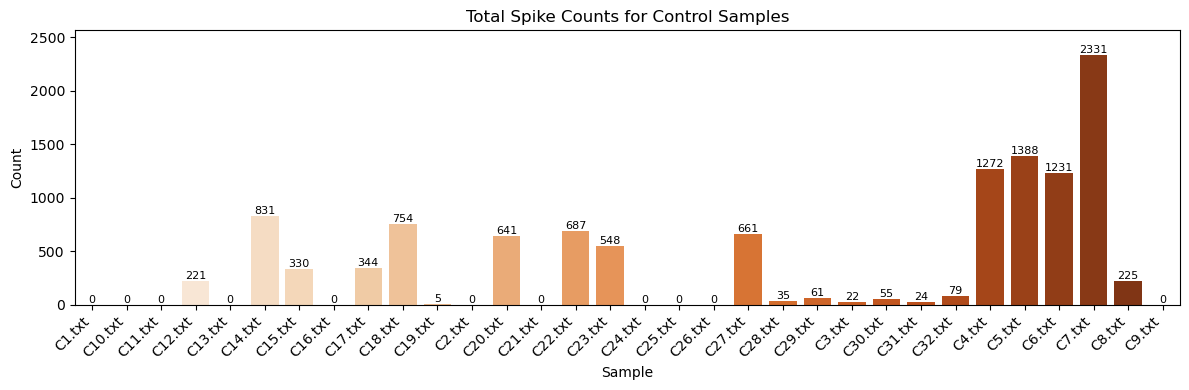

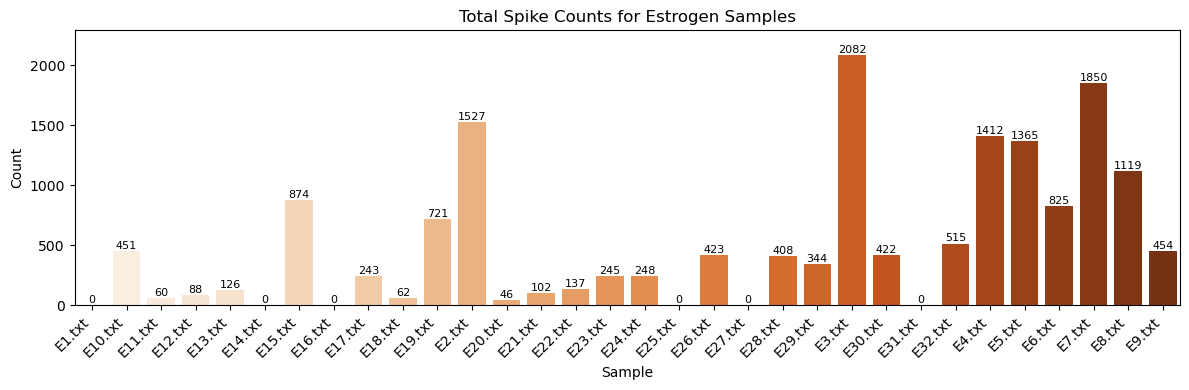

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sum spike counts per sample
spike_summary = all_features_df.groupby(["Sample", "Group"])["Firing Rate (Hz)"].sum().reset_index()

# Plot totals per sample with annotation
for group in ["Control", "Estrogen"]:
    subset = spike_summary[spike_summary["Group"] == group]

    plt.figure(figsize=(12, 4))
    ax = sns.barplot(data=subset, x="Sample", y="Firing Rate (Hz)", palette="Oranges", errorbar=None)
    plt.title(f"Total Spike Counts for {group} Samples")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Count")
    plt.ylim(0, subset["Firing Rate (Hz)"].max() * 1.1)

    # Annotate each bar
    for i, value in enumerate(subset["Firing Rate (Hz)"]):
        ax.text(i, value + 0.5, f"{int(value)}", ha='center', va='bottom', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()


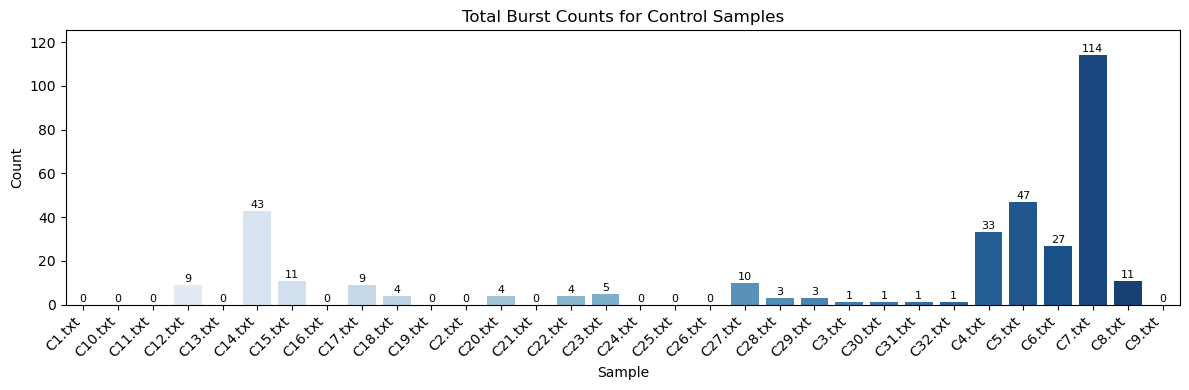

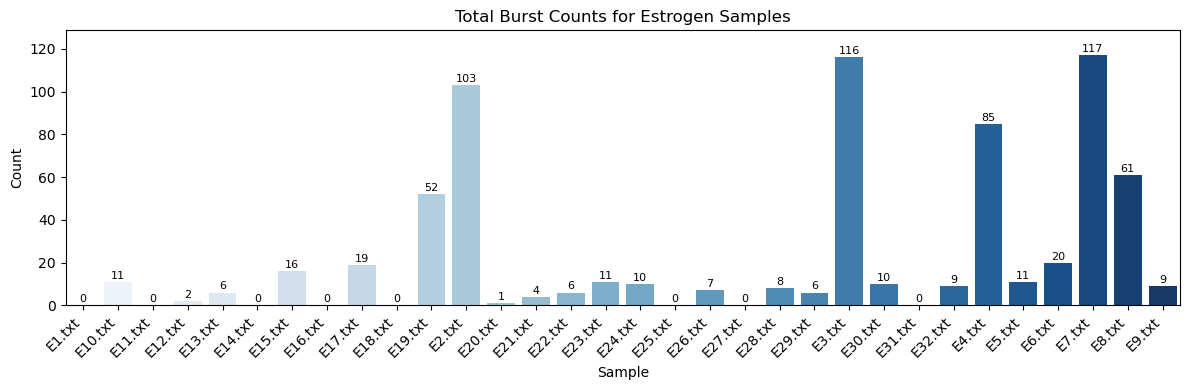

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate burst count per sample
burst_summary = all_features_df.groupby(["Sample", "Group"])["Burst Count"].sum().reset_index()

# Plot totals per sample with annotation
for group in ["Control", "Estrogen"]:
    subset = burst_summary[burst_summary["Group"] == group]

    plt.figure(figsize=(12, 4))
    ax = sns.barplot(data=subset, x="Sample", y="Burst Count", palette="Blues", errorbar=None)
    plt.title(f"Total Burst Counts for {group} Samples")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Count")
    plt.ylim(0, subset["Burst Count"].max() * 1.1)

    # Annotate bars
    for i, value in enumerate(subset["Burst Count"]):
        ax.text(i, value + 0.5, f"{int(value)}", ha='center', va='bottom', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()




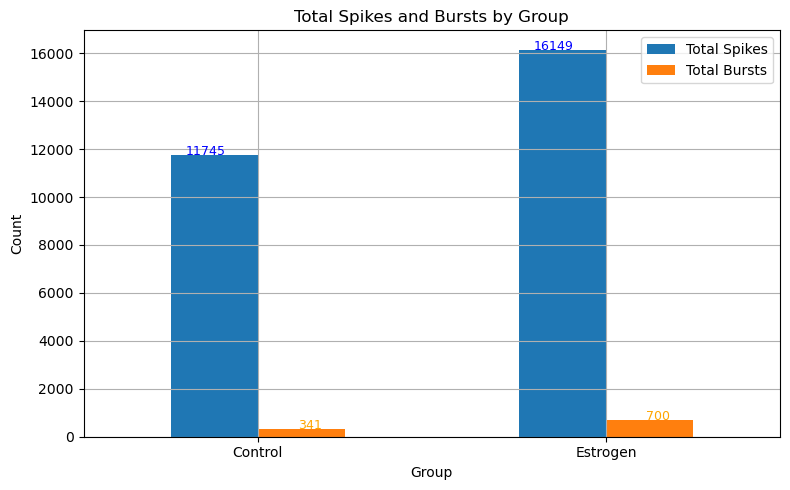

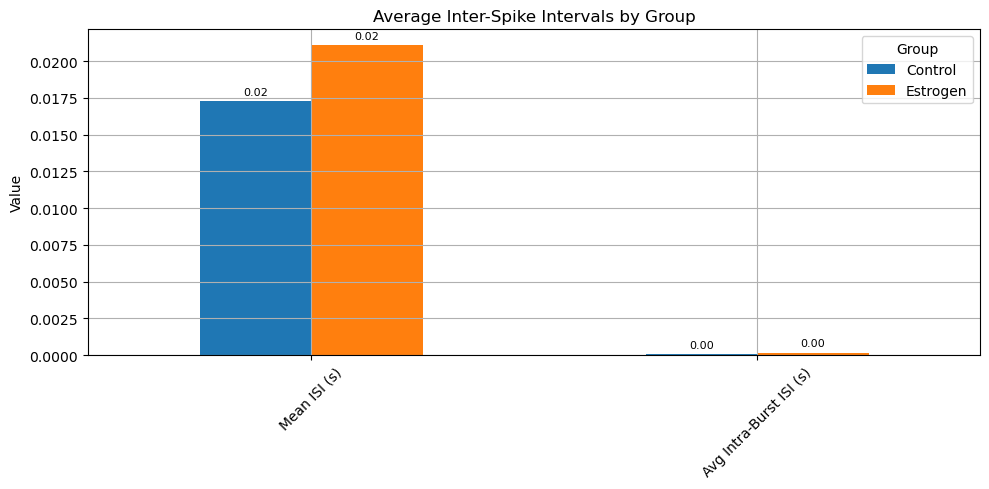

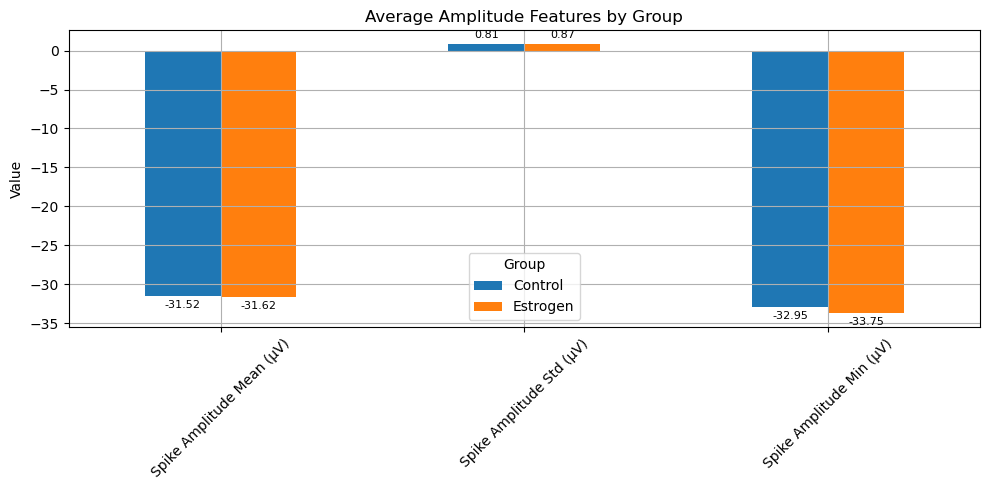

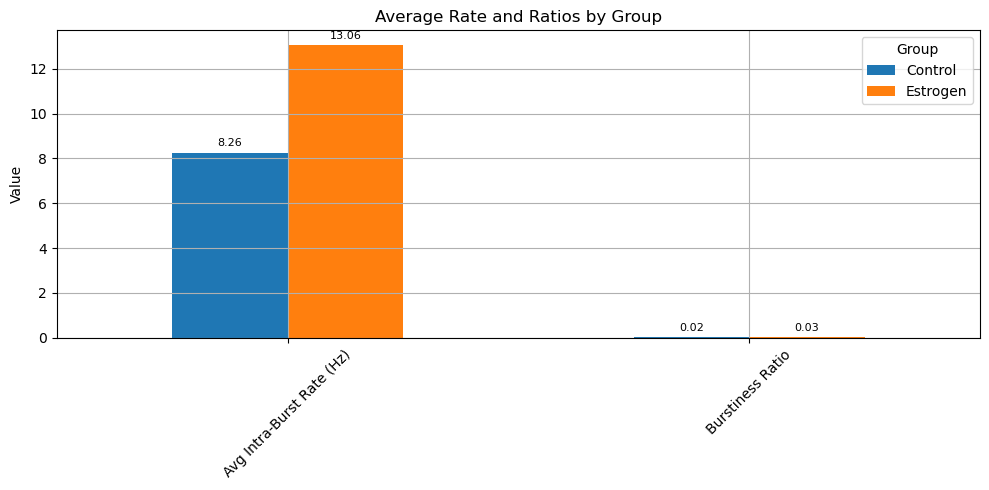

In [158]:
plot_group_totals(totals_df)
plot_group_averages(sample_summary_df)



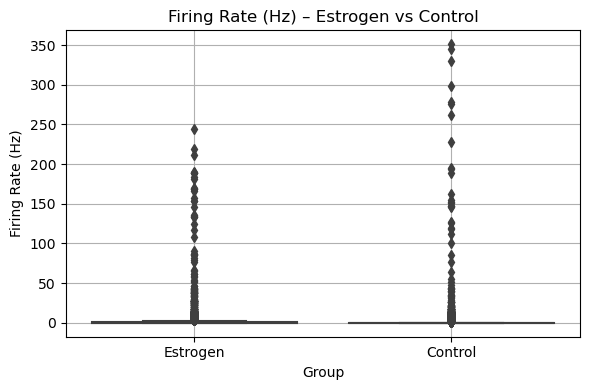

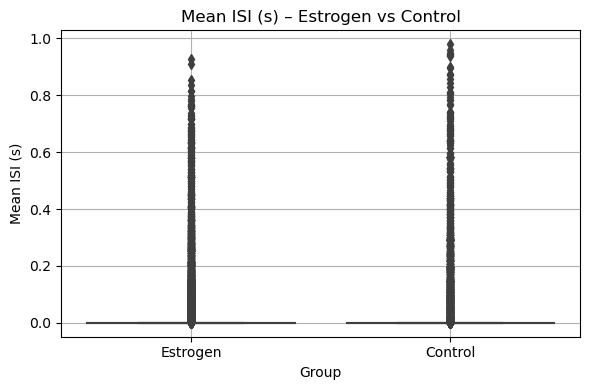

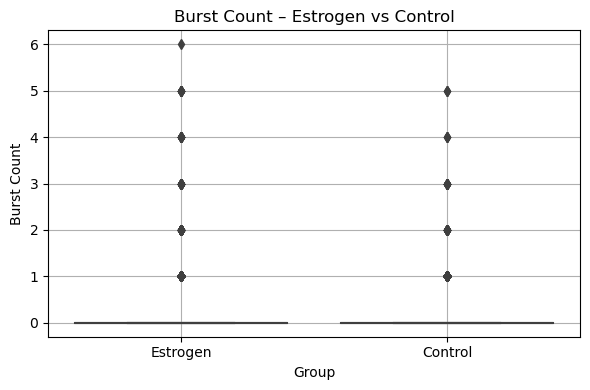

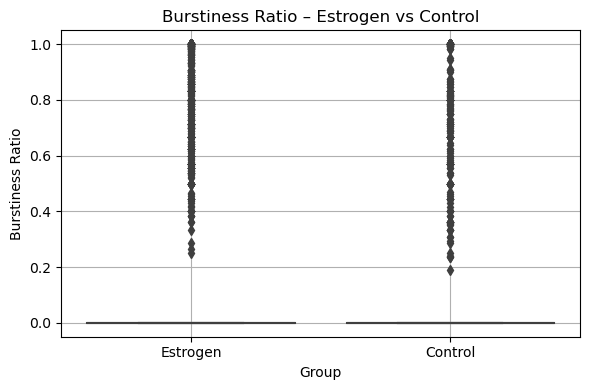

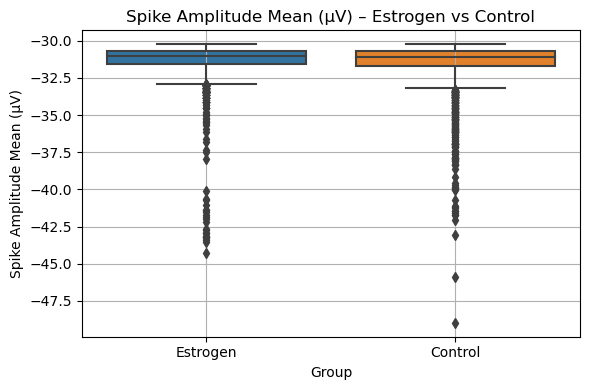

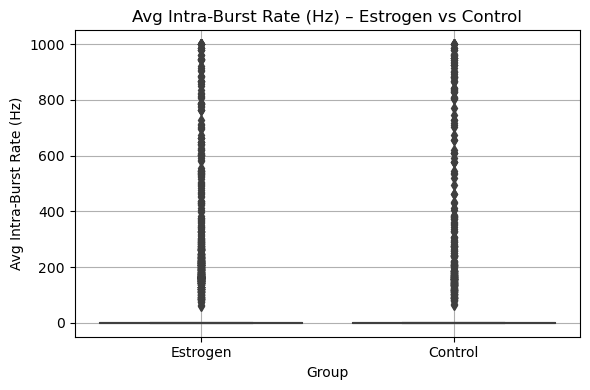

In [28]:
import seaborn as sns

# You can loop this for all features or pick key ones
features_to_compare = [
    "Firing Rate (Hz)", "Mean ISI (s)", "Burst Count", "Burstiness Ratio",
    "Spike Amplitude Mean (µV)", "Avg Intra-Burst Rate (Hz)"
]

for feature in features_to_compare:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=all_features_df, x="Group", y=feature)
    plt.title(f"{feature} – Estrogen vs Control")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Random Forest Classifier

Gradient Boosting Accuracy Scores: [0.84615385 0.69230769 0.46153846 0.61538462 0.66666667]
Mean Accuracy: 0.66 ± 0.12

Classification Report:
              precision    recall  f1-score   support

     Control       0.84      1.00      0.91        32
    Estrogen       1.00      0.81      0.90        32

    accuracy                           0.91        64
   macro avg       0.92      0.91      0.91        64
weighted avg       0.92      0.91      0.91        64



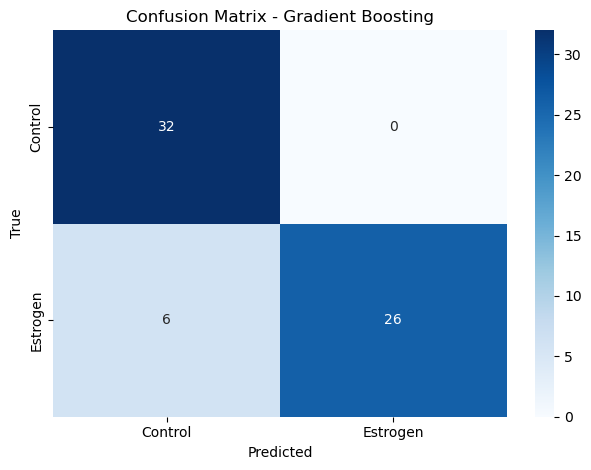

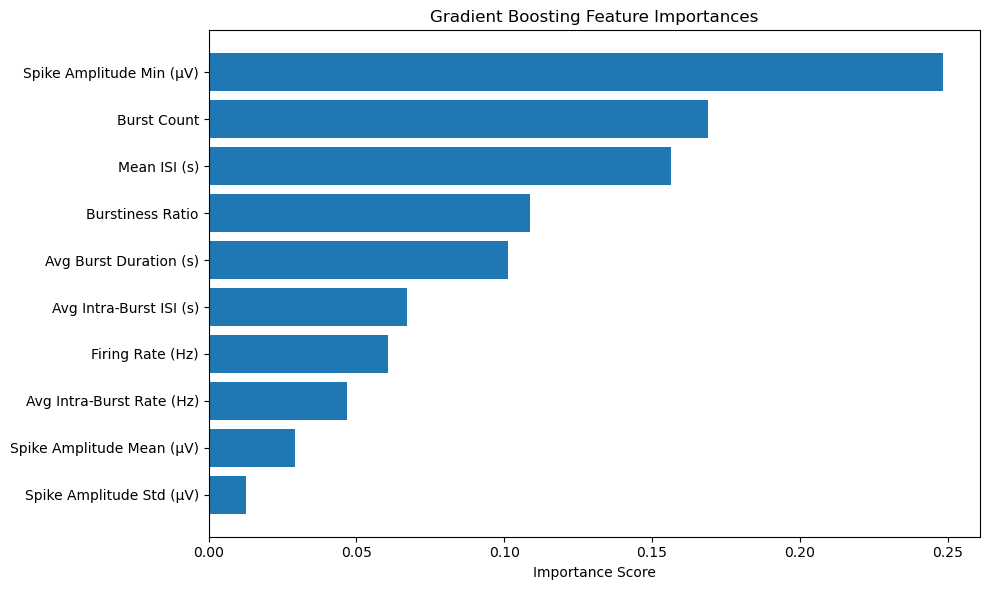

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create label column
sample_summary_df['Label'] = sample_summary_df['Group'].map({'Estrogen': 1, 'Control': 0})

# Extract features and labels
X = sample_summary_df.drop(columns=["Sample", "Group", "Window", "Label"], errors="ignore")
y = sample_summary_df["Label"]

# Handle missing values and scale
X = X.fillna(X.mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize model and stratified CV
gb_model = GradientBoostingClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
scores = cross_val_score(gb_model, X_scaled, y, cv=cv)
print("Gradient Boosting Accuracy Scores:", scores)
print(f"Mean Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

# Fit full model and predict
gb_model.fit(X_scaled, y)
y_pred = gb_model.predict(X_scaled)

# Classification report
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=["Control", "Estrogen"]))

# Confusion matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Control", "Estrogen"],
            yticklabels=["Control", "Estrogen"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Gradient Boosting")
plt.tight_layout()
plt.show()

# Feature importances
importances = gb_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.title("Gradient Boosting Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


PCA Projection and Decision Boundary

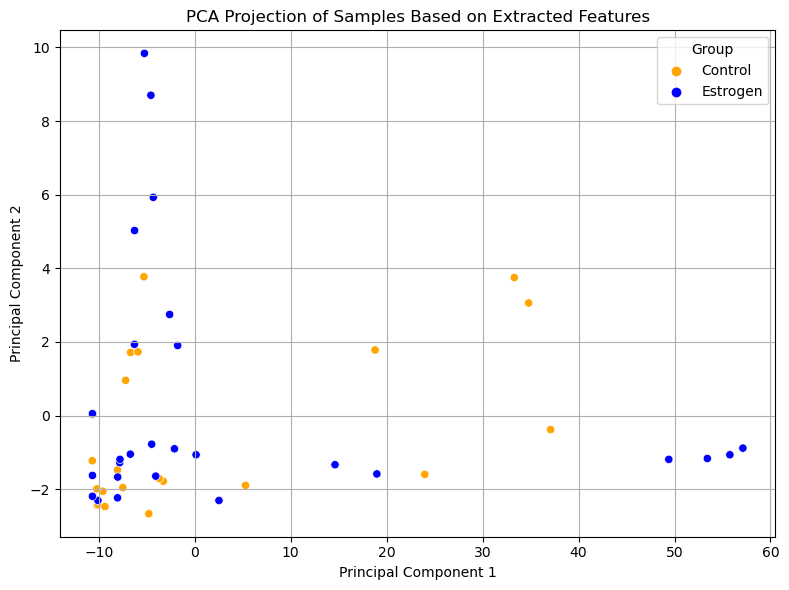

In [80]:
# Retry PCA and projection visualization now that sample_summary_df is confirmed to exist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare feature matrix and labels
X_vis = sample_summary_df.drop(columns=["Sample", "Group", "Window"], errors="ignore").copy()
y_vis = sample_summary_df["Group"]

# Fill missing values
X_vis = X_vis.fillna(X_vis.mean())

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vis)

# Prepare DataFrame for plotting
pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Group": y_vis
})

# Plot the PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Group", palette={"Estrogen": "blue", "Control": "orange"})
plt.title("PCA Projection of Samples Based on Extracted Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


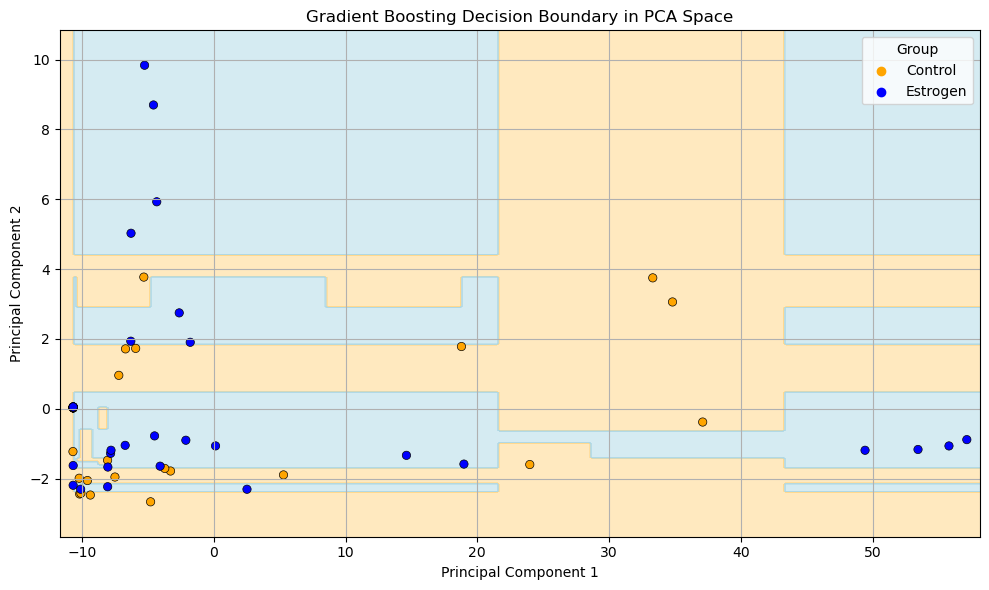

In [81]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(sample_summary_df["Group"])

# Fit GB on PCA data
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_pca, y_encoded)

# Create meshgrid
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = gb_model.predict(grid).reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 6))
cmap_background = ListedColormap(['#FFD580', '#ADD8E6'])  # Control: orange, Estrogen: blue
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.5)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=sample_summary_df["Group"],
                palette={"Estrogen": "blue", "Control": "orange"}, edgecolor='black')

plt.title("Gradient Boosting Decision Boundary in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
